In [14]:
pip install filterpy

     |████████████████████████████████| 177 kB 5.4 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=4e768ca33d36dedc00e420e2ce71cf81cfb88a7430bf42d7be4ce8544e47f8fa
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/IoT\ Test\ Project\ 1/utils /content/

cp: -r not specified; omitting directory '/content/drive/MyDrive/Colab Notebooks/IoT Test Project 1/utils'


In [18]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/IoT Test Project 1')

In [20]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [21]:
config_path = '/content/drive/MyDrive/Colab Notebooks/IoT Test Project 1/config/yolov3.cfg'
weights_path = '/content/drive/MyDrive/Colab Notebooks/IoT Test Project 1/config/yolov3.weights'
class_path = '/content/drive/MyDrive/Colab Notebooks/IoT Test Project 1/config/coco.names'
img_size = 416
conf_thres=0.8
nms_thres=0.4



In [22]:
model = Darknet(config_path,img_size=img_size)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [23]:
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

In [24]:
def detect_img(img):
  ratio = min(img_size/img.size[0], img_size/img.size[1])
  imw = round(img.size[0]*ratio)
  imh = round(img.size[1]*ratio)
  img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
  
  image_tensor = img_transforms(img).float()
  image_tensor = image_tensor.unsqueeze_(0)
  input_img = Variable(image_tensor.type(Tensor))

  with torch.no_grad():
    detections = model(input_img)
    detections = utils.non_max_suppression(detections,80,conf_thres,nms_thres)

  return detections[0]



In [32]:
img_path = "/content/drive/MyDrive/Colab Notebooks/IoT Test Project 1/images/blueangels.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_img(img)
interference_time = datetime.timedelta(seconds=time.time()-prev_time)
print('Interference Time : %s' % (interference_time))

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
img = np.array(img)
plt.figure()
# fig, ax = plt.subplots(1, figsize=(12,9))
# ax.imshow(img)
# pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
# pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
# unpad_h = img_size - pad_y
# unpad_w = img_size - pad_x
# if detections is not None:
#     unique_labels = detections[:, -1].cpu().unique()
#     n_cls_preds = len(unique_labels)
#     bbox_colors = random.sample(colors, n_cls_preds)
#     # browse detections and draw bounding boxes
#     for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
#         box_h = ((y2 - y1) / unpad_h) * img.shape[0]
#         box_w = ((x2 - x1) / unpad_w) * img.shape[1]
#         y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
#         x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
#         color = bbox_colors[int(np.where(
#              unique_labels == int(cls_pred))[0])]
#         bbox = patches.Rectangle((x1, y1), box_w, box_h,
#              linewidth=2, edgecolor=color, facecolor='none')
#         #ax.add_patch(bbox)
#         plt.text(x1, y1, s=classes[int(cls_pred)], 
#                 color='white', verticalalignment='top',
#                 bbox={'color': color, 'pad': 0})
# plt.axis('off')
# # save image
# plt.savefig(img_path.replace(".jpg", "-det.jpg"),        
#                   bbox_inches='tight', pad_inches=0.0)
# plt.show()

Interference Time : 0:00:00.140981


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

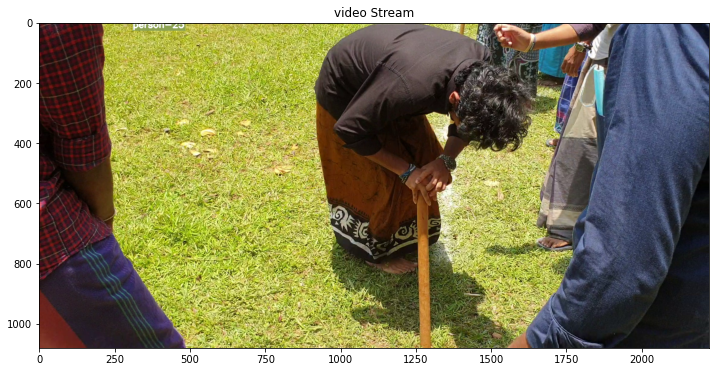

In [33]:
video_path = "/content/drive/MyDrive/Colab Notebooks/IoT Test Project 1/20210410_115448.mp4"

%pylab inline
import cv2
from IPython.display import clear_output

cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0,1,20)]

from sort import *
vid = cv2.VideoCapture(video_path)
mot_tracker = Sort()

for ii in range(40):
  ret, frame = vid.read()
  frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  pilimg = Image.fromarray(frame)
  detections = detect_img(pilimg)

  img = np.array(pilimg)
  pad_x = max(img.shape[0]-img.shape[1],0)*(img_size/max(img.shape))
  pad_y = max(img.shape[1]-img.shape[0],0)*(img_size/max(img.shape))

  unpad_h = img_size-pad_y
  unpad_w = img_size-pad_x

  if detections is not None:
    tracked_objects = mot_tracker.update(detections.cpu())

    unique_labels = detections[:,-1].cpu().unique()
    n_cls_preds = len(unique_labels)
    for x1,y1,x2,y2,obj_id,cls_pred in tracked_objects:
      box_h = int((y1-y2)/unpad_h)*img.shape[0]
      box_w = int((x1-x2)/unpad_w)*img.shape[0]

      y1 = int(((y1-pad_y//2)/unpad_h)*img.shape[0])
      x1 = int(((x1-pad_y//2)/unpad_w)*img.shape[1])

      color = colors[int(obj_id)%len(colors)]
      color = [i*255 for i in color]

      cls = classes[int(cls_pred)]
      cv2.rectangle(frame,(x1,y1),(x1+box_w,y1+box_h),color,4)
      cv2.rectangle(frame,(x1,y1-35),(x1+len(cls)*19+60,y1),color,-1)
      cv2.putText(frame,cls+"-"+str(int(obj_id)),(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),3)

fig = figure(figsize=(12,8))
title("video Stream")
imshow(frame)
clear_output(wait=True)

